### Data 620 - Final Project
### Bikram Barua and Leticia Salazar
### May 19, 2023

### Task:

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters.

## Sentiment Analysis on Trip Advisor Hotel Reviews

### The Dataset:

The data was obtained from [Kaggle.com](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews?resource=download) and it consists on 20k reviews from Trip Advisor.

* Data set has two columns Review and Rating
    * Review column has the text of each review
    * Rating column has rating values in integer form ranging from 1 - 5 stars

### Project Plan / Goals:

1. Identify the links between key travel related phrases and their related ranking sentiment
2. Evaluate the relationship between the text contents and the sentiment rating

    * Statistical Analysis:
        1. Word frequency count
        2. Percentage rating
        3. Word cloud by rating
        4. Review length
        5. Top 20 most common words
        
    * Sentiment Analysis
        * We will attempt to classify reveiws as negative, netural or positive and examine the following questions:
            1. Do useful review attributes affect rating?
            2. Does review text affect the review attribute?
            3. Can review text determine if a hotel received a high or low rating (stars)?

### Libraries

Below are the libraries used for this project

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import string
import re
from wordcloud import WordCloud
from textblob import TextBlob
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, adjusted_rand_score

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/letisalba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/letisalba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/letisalba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/letisalba/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load Data

The csv file is stored in GitHub and will be read from there for easy access. As noted, we have two columns `Review` and `Rating`.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/letisalba/Data-620/master/Week-12-15/tripadvisor_hotel_reviews.csv", encoding='latin-1')
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


Let's get a quick description on the column `Rating` for our data.

In [3]:
# Description of the dataframe
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


### Pre-Processing

Before we can start on the statistical and sentiment analysis on the data, we have to ensure that our data is pre-processed by removing any punctuation not needed, converting the `Review` column to lowercase. It would also help to visualize the `Rating` column.

In [4]:
# Function for removing the punctuations
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [5]:
# Viewing data without punctuation
df['Review']= df['Review'].apply(lambda x:remove_punctuation(x))
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4 experience hotel monaco seatt...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5


In [6]:
# Make all lowercase letters on Review column
df['Review']= df['Review'].apply(lambda x: x.lower())
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4 experience hotel monaco seatt...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5


In [7]:
# Check counts of all rating
df['Rating'].value_counts(normalize=True)

5    0.441853
4    0.294715
3    0.106583
2    0.087502
1    0.069348
Name: Rating, dtype: float64

### Rating and Review Visualization

Below some visualization on our `Review` and `Rating` columns. Based on the first chart below rating of 4 and 5 have the most counts compared to 1 - 3. So an initial assumption is that this dataset has more positive reviews / ratings than neutral or negative.

Text(0.5, 1.0, 'Count of reviews by rating')

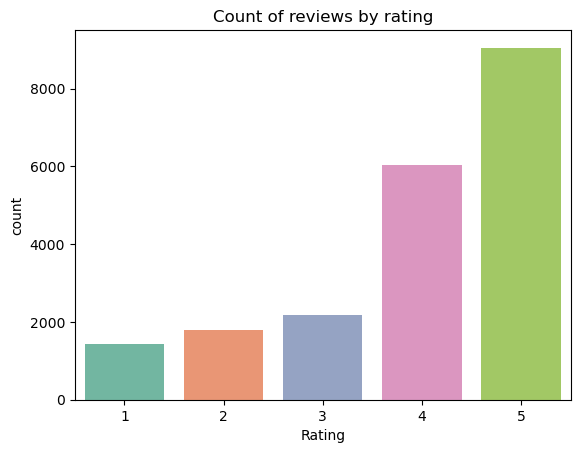

In [8]:
# Palette
cols = sns.color_palette("Set2")

# Visualize rating distribution
sns.countplot(data=df, x='Rating', palette=cols)
plt.title('Count of reviews by rating')

In [9]:
# Count length of the reviews
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,581
1,ok nothing special charge diamond member hilto...,2,1663
2,nice rooms not 4 experience hotel monaco seatt...,3,1395
3,unique great stay wonderful time hotel monaco ...,5,584
4,great stay great stay went seahawk game awesom...,5,1241


For this second visualization, the `Ratings` 4 and 5 have the highest density for the `Review` column

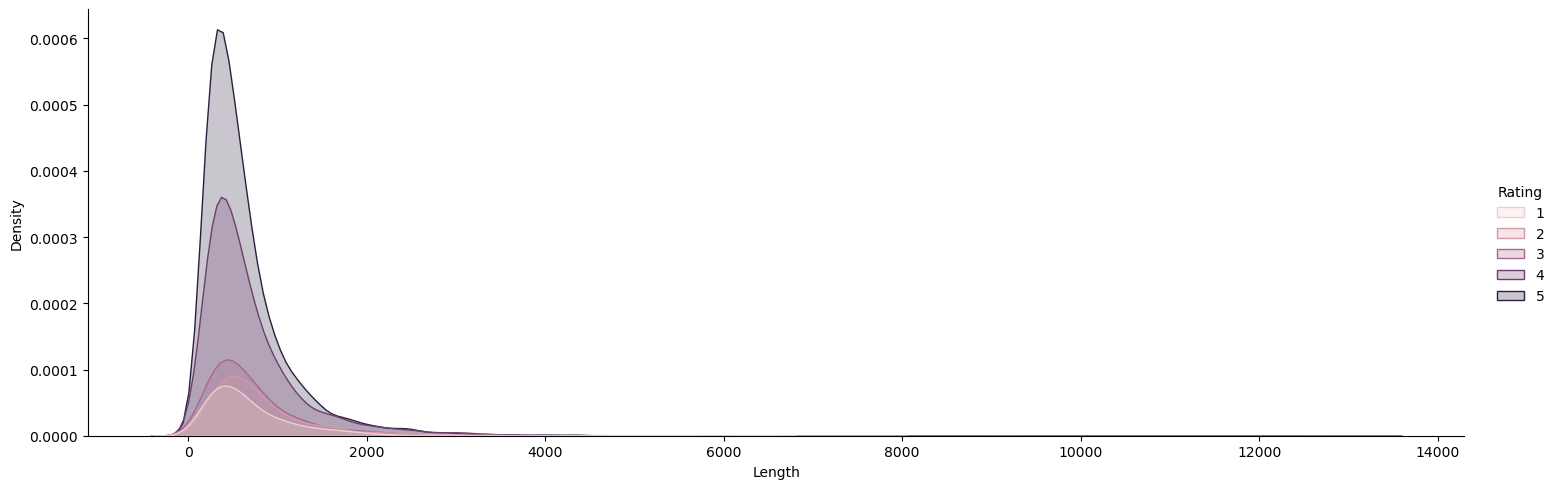

In [10]:
# Visualize length distribution based on the rating
sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=3)

### Tokenization

We will be tokenizing the `Review` column where we split up a larger body of text into smaller lines.

In [11]:
# tokenizing the Review column
df['Review']=df['Review'].astype(str)

def tokenize_review(review):
    tokens = word_tokenize(review)
    return tokens

df['tokens'] = df['Review'].apply(tokenize_review)
df.head()

,Review,Rating,Length,tokens
0,nice hotel expensive parking got good deal sta...,4,581,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,1663,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4 experience hotel monaco seatt...,3,1395,"[nice, rooms, not, 4, experience, hotel, monac..."
3,unique great stay wonderful time hotel monaco ...,5,584,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,1241,"[great, stay, great, stay, went, seahawk, game..."


### Removing Stopwords

From the text we tokenize, we will be removing the common stop words such as its, an, the, for, and that.

In [12]:
stopwords = nltk.corpus.stopwords.words('english')

#function for removing stopwords
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output


df['tokens']= df['tokens'].apply(lambda x:remove_stopwords(x))
df.head()

,Review,Rating,Length,tokens
0,nice hotel expensive parking got good deal sta...,4,581,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,1663,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4 experience hotel monaco seatt...,3,1395,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,unique great stay wonderful time hotel monaco ...,5,584,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,1241,"[great, stay, great, stay, went, seahawk, game..."


### Stemming

For example, words like ‘programmer’, ‘programming, ‘program’ will be stemmed to ‘program’.

In [13]:
porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text


df['stem']=df['tokens'].apply(lambda x: stemming(x))
df.head()

,Review,Rating,Length,tokens,stem
0,nice hotel expensive parking got good deal sta...,4,581,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expens, park, got, good, deal, s..."
1,ok nothing special charge diamond member hilto...,2,1663,"[ok, nothing, special, charge, diamond, member...","[ok, noth, special, charg, diamond, member, hi..."
2,nice rooms not 4 experience hotel monaco seatt...,3,1395,"[nice, rooms, 4, experience, hotel, monaco, se...","[nice, room, 4, experi, hotel, monaco, seattl,..."
3,unique great stay wonderful time hotel monaco ...,5,584,"[unique, great, stay, wonderful, time, hotel, ...","[uniqu, great, stay, wonder, time, hotel, mona..."
4,great stay great stay went seahawk game awesom...,5,1241,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game..."


### Lemmatization

It stems from the word but makes sure that it does not lose its meaning. Lemmatization has pre-defined dictionary that stores the context of words and checks the word in the dictionary while diminishing.

In [14]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

df['lemmatize']=df['stem'].apply(lambda x:lemmatizer(x))
df.head()


,Review,Rating,Length,tokens,stem,lemmatize
0,nice hotel expensive parking got good deal sta...,4,581,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expens, park, got, good, deal, s...","[nice, hotel, expens, park, got, good, deal, s..."
1,ok nothing special charge diamond member hilto...,2,1663,"[ok, nothing, special, charge, diamond, member...","[ok, noth, special, charg, diamond, member, hi...","[ok, noth, special, charg, diamond, member, hi..."
2,nice rooms not 4 experience hotel monaco seatt...,3,1395,"[nice, rooms, 4, experience, hotel, monaco, se...","[nice, room, 4, experi, hotel, monaco, seattl,...","[nice, room, 4, experi, hotel, monaco, seattl,..."
3,unique great stay wonderful time hotel monaco ...,5,584,"[unique, great, stay, wonderful, time, hotel, ...","[uniqu, great, stay, wonder, time, hotel, mona...","[uniqu, great, stay, wonder, time, hotel, mona..."
4,great stay great stay went seahawk game awesom...,5,1241,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game..."


### Statistical Analysis

From the lemmatize data we will then find the word frequency from each word and visualize the findings.

In [15]:
# word frequency count
freq = {}
for i in df['lemmatize']:
    for j in i:
        if j not in freq:
            freq[j] = 1
        else:
            freq[j] += 1
            
list(freq.items())[:25]            

[('nice', 13053),
 ('hotel', 52869),
 ('expens', 2015),
 ('park', 3195),
 ('got', 6185),
 ('good', 17109),
 ('deal', 1664),
 ('stay', 28240),
 ('anniversari', 413),
 ('arriv', 4854),
 ('late', 1584),
 ('even', 2100),
 ('took', 2942),
 ('advic', 513),
 ('previou', 737),
 ('review', 5296),
 ('valet', 514),
 ('check', 4966),
 ('quick', 896),
 ('easi', 2137),
 ('littl', 6243),
 ('disappoint', 2000),
 ('nonexist', 79),
 ('view', 5922),
 ('room', 46320)]

In [16]:
freq_df=pd.DataFrame(sorted(freq.items(),key=lambda x:x[1],reverse=True))

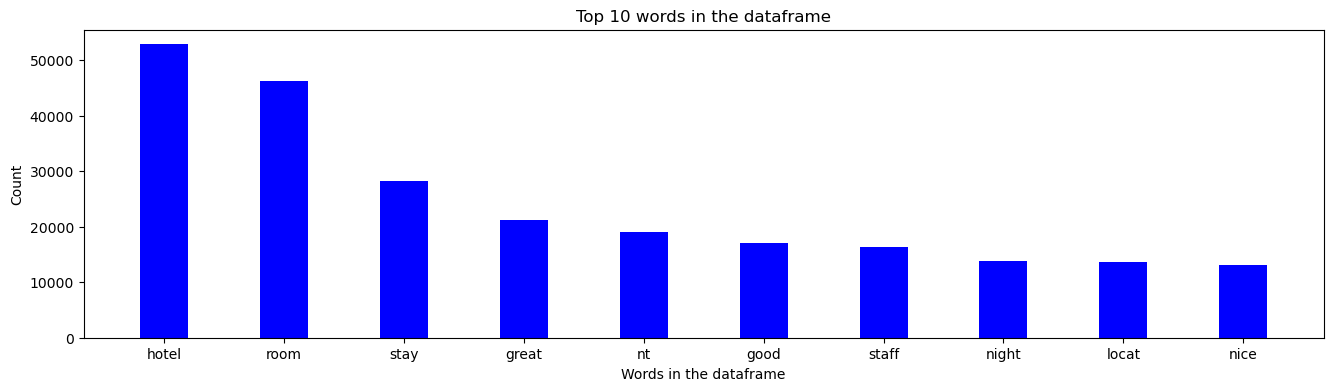

In [17]:
# Top 10 most common words
f1=freq_df[0][:10]
f2=freq_df[1][:10]

plt.figure(1,figsize=(16,4))
plt.bar(f1,f2,color ='blue',width = 0.4)
plt.xlabel("Words in the dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in the dataframe")
plt.savefig("wordfrequency.png")
plt.show()

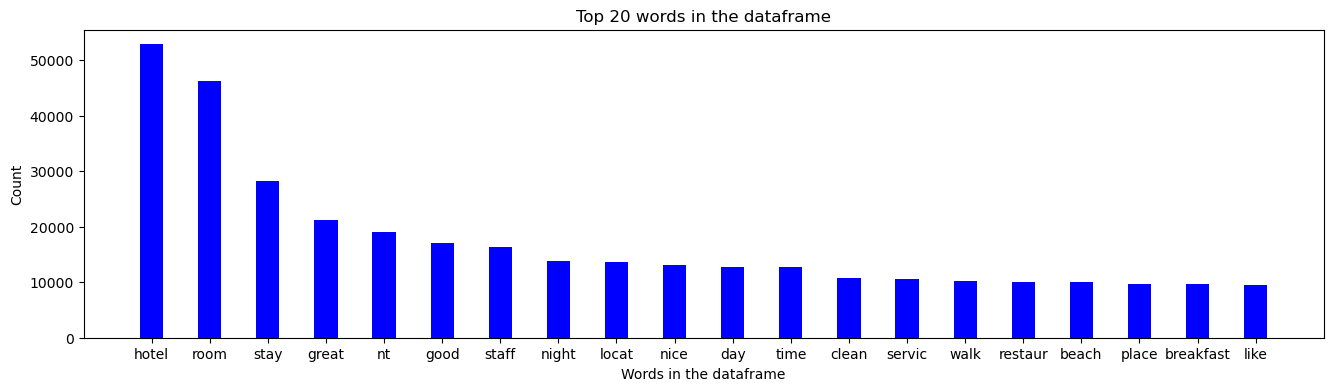

In [18]:
# Top 20 most common words
f1=freq_df[0][:20]
f2=freq_df[1][:20]

plt.figure(1,figsize=(16,4))
plt.bar(f1,f2,color ='blue',width = 0.4)
plt.xlabel("Words in the dataframe")
plt.ylabel("Count")
plt.title("Top 20 words in the dataframe")
plt.savefig("wordfrequency.png")
plt.show()

### Sentiment Analysis

We can perform sentiment analysis to analyze sentiment of each review and classify it as positive, negative or neutral. The results will be compared with the real rating of the hotel.

In [19]:
#this function give a value from -1 to 1 based on whether the data is negative or neutral or positive.
#def get_sentiment(review):
    #blob = TextBlob(review)
    #return blob.sentiment.polarity


#df['sentiment'] = df['Review'].apply(get_sentiment)
#df.head()


# Print the number of positive, negative, and neutral reviews
#print("Number of positive reviews:", len(df[df['sentiment'] > 0.2]))
#print("Number of negative reviews:", len(df[df['sentiment'] < -0.1]))
#print("Number of neutral reviews:", len(df[(df['sentiment'] > -0.1) AND (df['sentiment'] < 0.2)]) )

Number of positive reviews: 14453
Number of negative reviews: 627


Based on the function below we obtain the following results:
Positive reviews: 18840
Negative reviews: 1483
Neutral reviews: 168

In [20]:
# Define a function to classify the sentiment of a review
sia = SentimentIntensityAnalyzer()

def get_sentiment(review):
    scores = sia.polarity_scores(review)
    sentiment_score = scores['compound']
    if sentiment_score > 0.1:
        return 'positive'
    elif sentiment_score < -0.1:
        return 'negative'
    else:
        return 'neutral'
    
# Apply function on dataset copy
df2 = df.copy()
df2['Predicted_Sentiment'] = df2['Review'].apply(get_sentiment)

# Print the number of positive, negative, and neutral reviews
print("Number of positive reviews:", len(df2[df2['Predicted_Sentiment'] == 'positive']))
print("Number of negative reviews:", len(df2[df2['Predicted_Sentiment'] == 'negative']))
print("Number of neutral reviews:", len(df2[df2['Predicted_Sentiment'] == 'neutral']))


# Map the rating column to create new column true sentiment
df2['True_Sentiment'] = df2['Rating'].map({1: 'negative', 
                                           2: 'negative', 
                                           3: 'neutral', 
                                           4: 'positive', 
                                           5: 'positive'})

Number of positive reviews: 18840
Number of negative reviews: 1483
Number of neutral reviews: 168


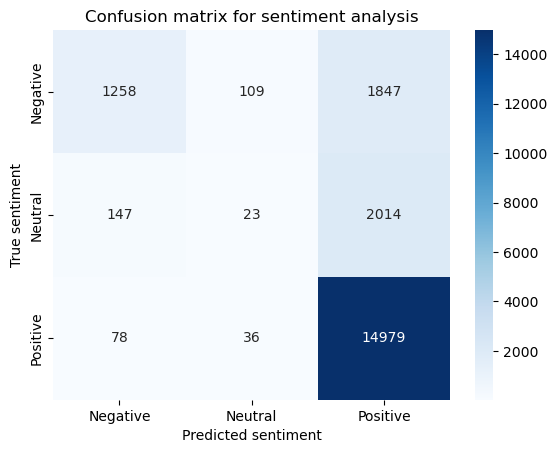

In [21]:
# Calculate confusion matrix
cm = confusion_matrix(df2['True_Sentiment'], df2['Predicted_Sentiment'])

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.title('Confusion matrix for sentiment analysis')
plt.show()

In [22]:
print("\nClassification report:\n", classification_report(df2['True_Sentiment'], 
                                                          df2['Predicted_Sentiment']))


Classification report:
               precision    recall  f1-score   support

    negative       0.85      0.39      0.54      3214
     neutral       0.14      0.01      0.02      2184
    positive       0.80      0.99      0.88     15093

    accuracy                           0.79     20491
   macro avg       0.59      0.46      0.48     20491
weighted avg       0.73      0.79      0.74     20491



### Visualizations

First we start with a word cloud, as seen below, the words `hotel`, `room`, `resort`, `time`, and `day` show the largest from our `Review` column. 

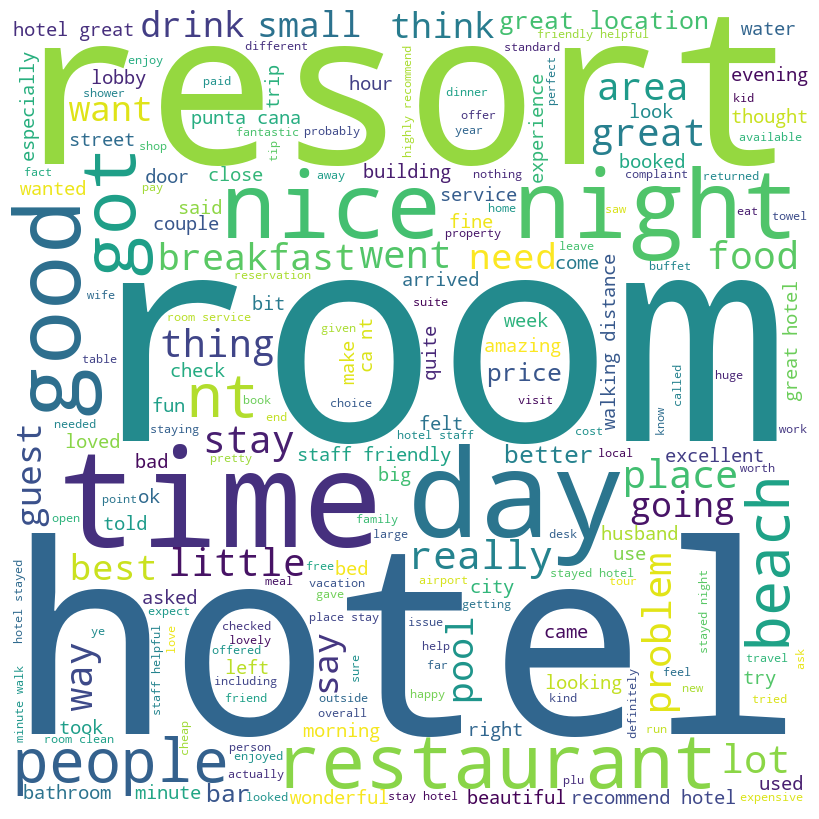

In [23]:
# WordCloud
text = ' '.join(df['Review'])
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png")
plt.show()

#### Scatterplot of Sentiment vs Rating

As seen below, in each of our ratings there's a couple of outliers.

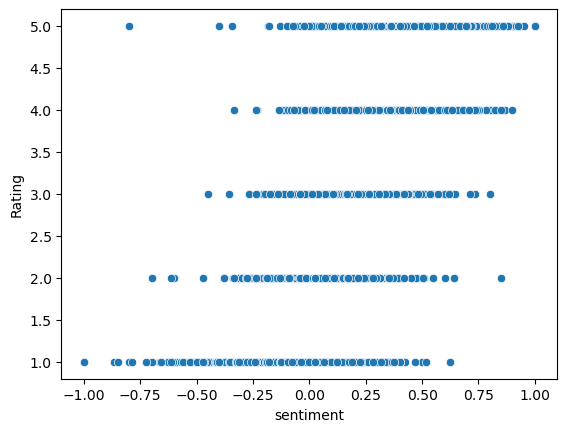

In [24]:
# scatterplot of sentiment vs rating
sns.scatterplot(data=df, x='sentiment', y='Rating')
plt.savefig("scatterplot.png")
plt.show()

#### Heatmap of correlation between Sentiment and Rating

Each square shows the correlation between the variables on each axis. Correlation ranges from -1 to +1. Values closer to zero means there is no linear trend between the two variables. The close to 1 the correlation is the more positively correlated they are; that is as one increases so does the other and the closer to 1 the stronger this relationship is. A correlation closer to -1 is similar, but instead of both increasing one variable will decrease as the other increases. The diagonals are all 1 / tan because those squares are correlating each variable to itself (so it's a perfect correlation. Based on this, there is a strong positive correlation between the variables.

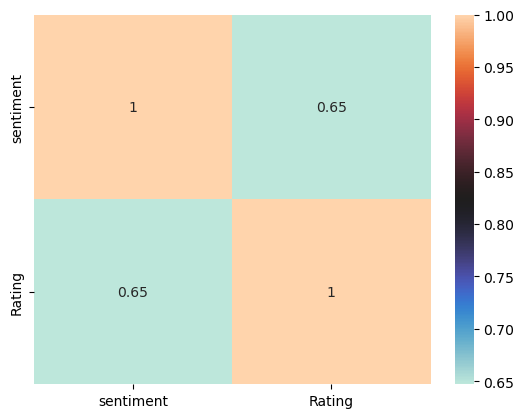

In [25]:
sns.heatmap(df[['sentiment', 'Rating']].corr(), annot=True, cmap='icefire')
plt.savefig("correlationheatmap.png")
plt.show()

### Advanced NLP Techniques:

Topic modeling with Latent Dirichlet Allocation (LDA) are a type of statistical language models used for uncovering hidden structure in a collection of texts. 

In [26]:
texts = df['lemmatize'].tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


lda_model = models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=10,passes=10)

for i, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=False):
    print(f"Topic {i+1}: {' '.join([word[0] for word in topic])}")

Topic 1: comedi clever 100m moma regina introduct sisterinlaw tre no1 fluke
Topic 2: mate et rural haha throught pill cowboy convenientth dumb fo
Topic 3: hotel servic stay properti experi guest staff star expect qualiti
Topic 4: room hotel stay bed nt good nice bathroom floor night
Topic 5: room hotel nt day check stay arriv time ask book
Topic 6: hotel stay room great staff love help wonder servic excel
Topic 7: beach resort pool food good nt great day time restaur
Topic 8: hotel locat great walk stay room good breakfast staff clean
Topic 9: fruit egg juic breakfast bread cereal fresh coffe chees silla
Topic 10: secret 5min unlucki awsom fascin moneyth biggi lick wantedth cuban


### Conclusion:

To answer our questions from our project goals:

1. Do useful review attributes affect rating?

* Yes, useful review attributes can have an impact on ratings. When users evaluate a product or service, they often consider the usefulness of the reviews they read. Useful review attributes can include factors such as thoroughness, clarity, relevance, and helpfulness of the information provided. When potential customers or users come across reviews that are deemed useful, it can influence their perception and decision-making process. Positive attributes in reviews, such as detailed explanations, specific examples, unbiased opinions, and constructive criticism, can provide valuable insights that help individuals assess the quality and suitability of a product or service.

2. Does review text affect the review attribute?

* Yes, the review text itself can greatly impact the review attribute. The content and tone of the review text can influence how readers perceive and evaluate the review. Here are a few ways in which review text can affect review attributes:

    * Language and clarity: The clarity of the review text can make a review more comprehensible and easier to understand. Well-written reviews that use clear and concise language are generally considered more useful and valuable. Reviews that are poorly written, contain grammatical errors, or are difficult to understand may be perceived as less credible or helpful.

    * Detail and specificity: Reviews that provide specific details about the reviewer's experience, highlighting both positive and negative aspects, tend to be more informative. Specific examples, anecdotes, and specific details about the product or service can enhance the usefulness of the review. Vague or generic reviews without specific information may be seen as less valuable.

    * Relevance and context: Review texts that provide relevant information and context are often considered more helpful. Reviews that explain how the product or service is used in a particular context or how it compares to alternatives can assist readers in making more informed decisions. Irrelevant or off-topic review texts may be viewed as less valuable.

    * Objectivity and bias: Reviews that are perceived as objective and unbiased are typically considered more trustworthy. It is important for reviewers to provide an honest assessment without personal biases or hidden agendas. Reviews that appear overly positive or negative without sufficient justification may be regarded as less reliable.

    * Overall sentiment: The overall sentiment conveyed in the review text can also influence the review attribute. Positive reviews that express satisfaction and highlight the benefits of the product or service are more likely to be perceived as useful and contribute positively to review attributes. Conversely, negative reviews that articulate specific concerns or problems can also be seen as informative and valuable.

* While review attributes are influenced by various factors, the content and quality of the review text play a significant role in shaping how reviews are perceived and evaluated by others.



3. Can review text determine if a hotel received a high or low rating (stars)?

* Yes, review text can play a significant role in determining whether a hotel receives a high or low rating (stars). When users write reviews for hotels, they often provide detailed feedback about their experiences, including aspects such as cleanliness, service quality, amenities, location, and overall satisfaction. These factors, when expressed in the review text, can influence the rating given to the hotel.

    * Here's how review text can contribute to high or low ratings:

        * Positive aspects: Reviewers who express positive experiences in their text, highlighting factors such as excellent service, clean rooms, comfortable beds, great amenities, or exceptional customer care, are more likely to give the hotel a higher rating. When potential guests read positive reviews that emphasize these positive attributes, they are more inclined to rate the hotel higher as well.

        * Negative aspects: Conversely, review text that focuses on negative experiences, such as poor service, unclean rooms, uncomfortable beds, inadequate amenities, or issues with the hotel's facilities, can result in a lower rating. Negative reviews that highlight specific problems or shortcomings can deter potential guests and contribute to a lower overall rating for the hotel.

        * Overall satisfaction: Review text often reflects the overall satisfaction of the reviewer with their stay at the hotel. If the review text indicates a high level of satisfaction, describing a pleasant experience, great value for money, or exceeding expectations, it is likely to contribute to a higher rating. On the other hand, review text expressing disappointment, frustration, or dissatisfaction can lead to a lower rating.

* 
It's important to note that review text is just one aspect considered when determining a rating. Other factors, such as the number of reviews, the average rating across multiple reviews, and the specific rating scale used by the platform, also influence the final rating of a hotel. However, review text provides valuable insights into the experiences of guests and can heavily influence the rating given to a hotel.


### References:

* LARXEL. (2020, September 30). Trip advisor hotel reviews. Kaggle. Retrieved April 27, 2023, from https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews?resource=download